In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage
import torch

In [2]:
import glob
vec_path = glob.glob("../data/vecs/*.pkl")[0]
vec_path

'../data/vecs/abo16-finetune-flc-psm.03.v0.vec.pkl'

In [3]:
with open(vec_path, "rb") as fin:
    evals = pickle.load(fin)

In [4]:
ans = evals["ans"]
ans_lst = sorted(set(ans))
preds = evals["preds"]
mask = np.array([x == y for x, y in zip(ans, preds)])

hlast = evals["last"][mask, :]
h0 = evals["h0"][mask, :]
h6 = evals["h6"][mask, :]
ans = np.array(ans)[mask]

In [5]:
len(ans)

1341

## PCA

In [22]:
def plot_proj(hvec, k, dim1=0, dim2=1):
    pca_h = PCA(k)
    h_proj = pca_h.fit_transform(hvec)
    h_norm = h_proj / np.linalg.norm(h_proj, axis=1)[:, np.newaxis]
    ans_idx = [ans_lst.index(x) for x in ans]
    plt.scatter(h_norm[:, dim1], h_norm[:, dim2], c=ans_idx, cmap="tab20")
    plt.xlabel("PCA " + str(dim1+1), size=16)
    plt.ylabel("PCA " + str(dim2+1), size=16)
    return h_norm, legend

['Amis',
 'Atayal',
 'Bunun',
 'Cou',
 "Hla'alua",
 'Kanakanavu',
 'Kavalan',
 'Paiwan',
 'Pinuyumayan',
 'Rukai',
 'Sakizaya',
 'Saysiyat',
 'Seediq',
 'Thau',
 'Truku',
 'Yami']

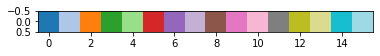

In [26]:
plt.imshow(np.arange(16)[:, np.newaxis].T, cmap="tab20")
ans_lst

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


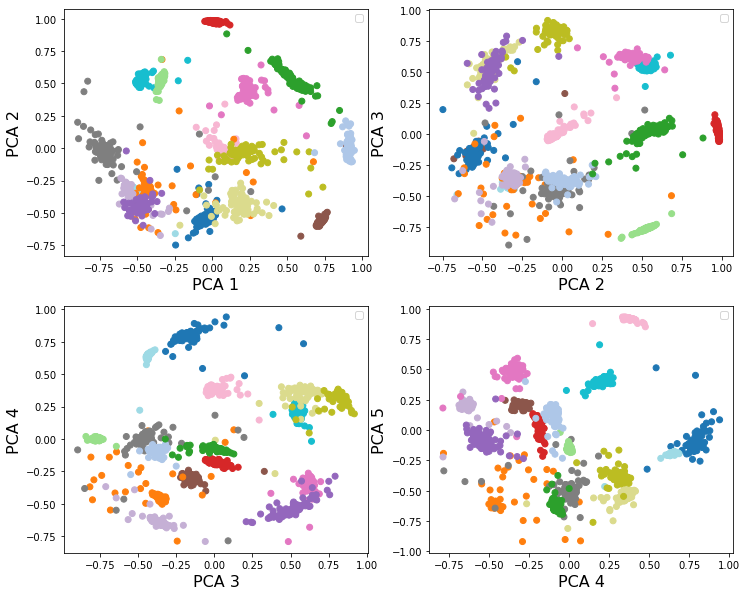

In [21]:
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
hlast_norm = plot_proj(hlast, 5, 0, 1)
plt.subplot(2, 2, 2)
_ = plot_proj(hlast, 5, 1, 2)
plt.subplot(2, 2, 3)
_ = plot_proj(hlast, 5, 2, 3)
plt.subplot(2, 2, 4)
_ = plot_proj(hlast, 5, 3, 4)

In [52]:
def compute_cluster(h_norm):
    medoids = []
    for ans_x in ans_lst:
        mat = h_norm[ans==ans_x]
        D = squareform(pdist(mat, metric='cosine'))
        med_idx = np.argmin(D.sum(axis=0))
        medoids.append(mat[med_idx])   
        
    Dm = pdist(medoids, metric='cosine')
    Zm = linkage(Dm, method='ward')
    
    plt.figure(figsize=(8,5))
    Rm = dendrogram(Zm, labels=ans_lst, leaf_rotation=45, link_color_func=lambda x: "black")        
    xlabels = plt.gca().get_xticklabels()
    _ = plt.gca().set_xticklabels(xlabels, ha='right', size=16)
    plt.title("Clustering with speech vectors", size=20)
    
    return medoids, Dm, Rm

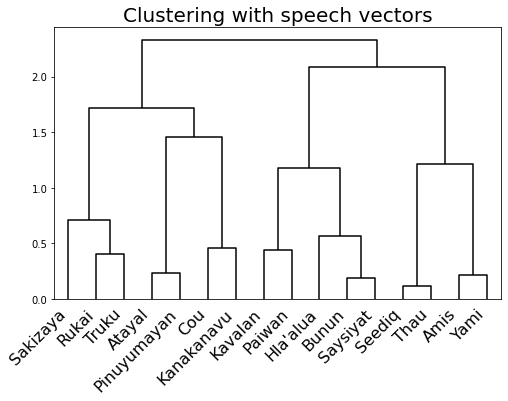

In [53]:
medoids_last, dm, rm = compute_cluster(hlast_norm)

In [87]:
def plot_medoids_dist(medoids, Dm ,Rm):
    plt.figure(figsize=(8, 6))
    plt.imshow(squareform(Dm)[Rm["leaves"], :][:, Rm["leaves"]], cmap="summer_r")
    plt.gca().set_xticks(np.arange(0, len(ans_lst)))
    lang_labels = [ans_lst[x] for x in Rm["leaves"]]
    plt.gca().set_xticklabels(lang_labels, rotation=45, ha="right", size=16)
    plt.gca().set_yticks(np.arange(0, len(ans_lst)))
    _ = plt.gca().set_yticklabels(lang_labels, size=16)
    plt.title("Distance between medoids", size=20)
    
    plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
    cax = plt.axes([0.85, 0.1, 0.075, 0.8])
    plt.colorbar(cax=cax)
    

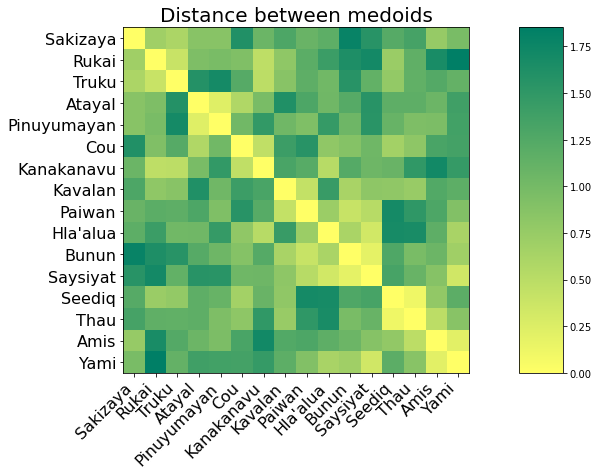

In [88]:
plot_medoids_dist(medoids_last, dm, rm)

## Compute LDA

In [95]:
feat_phones = pd.read_csv("../data/langfeats/feat_phones.csv", index_col=0)

In [96]:
from scipy.stats import entropy
feat_mat = np.array(feat_phones)
p = (feat_mat==1).sum(axis=0)/12
log2p = lambda x: [np.log2(p) if p>0 else 0 for p in x]
feat_entropies = -p*log2p(p)-(1-p)*log2p(1-p)
feat_entropies_orders = feat_entropies.argsort()[::-1]

In [97]:
p=np.array([0.75]);-p*log2p(p)-(1-p)*log2p(1-p)

array([0.81127812])

In [98]:
from tqdm.auto import tqdm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
feat_ldas = []

def compute_lda(hnorm):
    feat_ldas = []
    for feat_idx in feat_entropies_orders:    
        feat_ent = feat_entropies[feat_idx]
        if feat_ent < 1e-4: continue

        feat_x = feat_phones.iloc[:, feat_idx]
        feat_name = feat_x.name
        ymap = feat_x.to_dict()

        lda = LinearDiscriminantAnalysis()            
        y = [ymap.get(x,0) for x in ans]
        lda.fit(hnorm, y)
        score = lda.score(hnorm, y)
        coefs = lda.coef_[0]
        intc = lda.intercept_[0]
        feat_ldas.append(dict(
            feat_name=feat_name, 
            feat_ent=feat_ent,
            score=score,
            coefs=coefs, intc=intc
        ))
    return feat_ldas

In [99]:
lda_last = compute_lda(hlast_norm)

NameError: name 'h0_norm' is not defined

In [100]:
lda_items = []
for lda_x in lda_last:
    feat_name = lda_x["feat_name"]
    feat_ent = lda_x["feat_ent"]    
    feat_sum = feat_phones[feat_name].sum()
    lda_items.append((
        feat_name, feat_sum, feat_ent, 
        lda_x["score"]
    ))

In [101]:
lda_data = pd.DataFrame(lda_items, 
                        columns=["feat_name", "feat_sum", "feat_ent", 
                                 "hlast_score"])

In [102]:
lda_data.to_csv("../data/langfeats/lda_scores_last.csv")

In [104]:
feat_candids = lda_data.loc[lda_data.feat_ent>0.95, :].sort_values("hlast_score", ascending=False)

In [105]:
feat_candids

,feat_name,feat_sum,feat_ent,hlast_score
7,Unaspiratedvoicelessuvularplosive,5,0.979869,0.979866
5,Consonantclusters,7,0.979869,0.923192
11,voicedalveolarplosive,7,0.979869,0.921700
12,voicedlabiodentalnonsibilantfricative,5,0.979869,0.862789
9,Midbackvowel,5,0.979869,0.862043
10,Midcentralvowel,7,0.979869,0.841909
0,midfrontunroundedvowel,6,1.000000,0.829978
1,voicedvelarplosive,6,1.000000,0.812081
2,voicelessuvularplosive,6,1.000000,0.797912
13,midcentralunroundedvowel,7,0.979869,0.782252


In [108]:
lda_data.sort_values("hlast_score", ascending=True)

,feat_name,feat_sum,feat_ent,hlast_score
14,bilabialvoicedplosive,7,0.979869,0.625652
3,Alveolarvoicedplosive,6,1.000000,0.679344
47,Alveolartrill,9,0.811278,0.712901
37,voicedalveolartrill,9,0.811278,0.712901
6,Velarvoicedplosive,5,0.979869,0.732289
...,...,...,...,...
82,voicedalveolartaporflap,1,0.413817,0.997763
91,voiceduvularnonsibilantfricative,1,0.413817,0.997763
98,voicedalveolarlateralfricative,1,0.413817,0.997763
95,highcentralunroundedvowel,1,0.413817,0.999254


<AxesSubplot:ylabel='Density'>

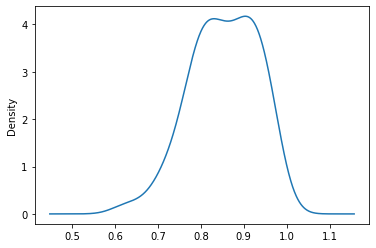

In [117]:
lda_data.loc[lda_data.feat_ent>0.6, "hlast_score"].plot.kde()

<AxesSubplot:ylabel='Density'>

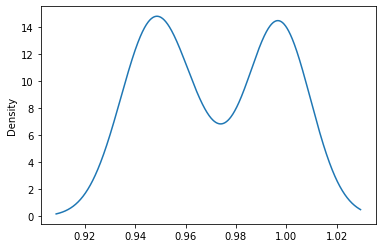

In [118]:
lda_data.loc[lda_data.feat_ent < .6, "hlast_score"].plot.kde()